<b>Importing the necessary libraries</b>

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


<b>Creating variables for training and validation data</b>

In [3]:
train='/content/drive/My Drive/image_data/train'

In [4]:
val='/content/drive/My Drive/image_data/validation'

<b>Image Preprocessing</b>

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)


#Creating generator object of training images
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 200 images belonging to 2 classes.


In [7]:
val_datagen=ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

val_generator = train_datagen.flow_from_directory(val,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 22 images belonging to 2 classes.


<b>Visualizing the images</b>

In [8]:
labels=['chicken','sparrow']

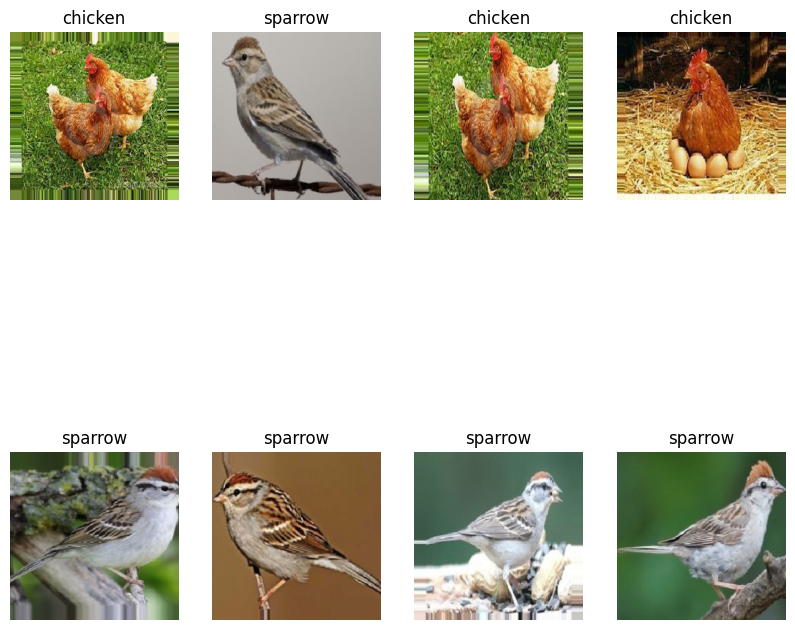

In [9]:
import numpy as np
plt.figure(figsize=(10,10))
batch,p = train_generator.next()
for i in range(1,9):
   plt.subplot(2,4, i)
   
   image = batch[i]
   plt.imshow(image)

   #The labels are one-hot encoded, so need to find position with value 1
   plt.title(labels[np.argmax(p[i])])
   plt.axis('off')
plt.show()

<b>Creating the model</b>

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions

In [11]:
#We are using a VGG-16 model with "imagenet" weights
model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(256,256,3))

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
#These layers will not be trained
for layers in model.layers:
  layers.trainable=False


#Taking the last layer of the VGG-16 layer
last_output = model.output


#Adding a Flatten layer
vgg_x = Flatten()(last_output)


#Adding a Dense layer for linear output
vgg_x = Dense(128, activation = 'relu')(vgg_x)


#The output layer will give 6 values, a probability distribution for each label
vgg_x = Dense(2, activation = 'softmax')(vgg_x)


#Connecting the linear layers to the VGG-16 model
vgg16_final_model = Model(model.input, vgg_x)


#Compiling the model
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])


In [13]:
vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
#Fitting the model
vgg16_final_model.fit(train_generator,steps_per_epoch=len(train_generator),epochs=3,validation_data=val_generator,validation_steps=len(val_generator))

Epoch 1/3
7/7 [==============================] - 65s 7s/step - loss: 0.5798 - accuracy: 0.7050 - val_loss: 0.4884 - val_accuracy: 0.7727
Epoch 2/3
7/7 [==============================] - 9s 1s/step - loss: 0.3822 - accuracy: 0.9200 - val_loss: 0.3345 - val_accuracy: 0.9545
Epoch 3/3
7/7 [==============================] - 7s 852ms/step - loss: 0.2608 - accuracy: 0.9700 - val_loss: 0.2396 - val_accuracy: 0.9545


In [ ]:
#Saving the model
vgg16_final_model.save('vgg_multi_classifier.h5')

In [ ]:
#Loading the model
from keras.models import load_model
vgg_m=load_model('vgg_multi_classifier.h5')

<b>Prediction</b>

In [16]:
pred='/content/drive/My Drive/image_data/test/'

In [20]:
test=dict()
test["image"]=[]
test["label"]=[]
for l in ["chicken","sparrow"]:
  for name in os.listdir(os.path.join(pred,l)):
    test["image"].append(name)
    test["label"].append(l)

In [21]:
import pandas as pd
test_data=pd.DataFrame(test)
test_data.head()

,image,label
0,628.jpeg,chicken
1,630.jpeg,chicken
2,619.jpeg,chicken
3,635.jpeg,chicken
4,613.jpeg,chicken


In [27]:
from keras.preprocessing import image
for i in range(len(test_data)): 
  image=os.path.join(pred,test_data.loc[i,"label"],test_data.loc[i,"image"])
  img_pred_1=tf.keras.utils.load_img(image,target_size=(256,256))
  img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
  img_pred_1=np.expand_dims(img_pred_1, axis=0)
  rslt= vgg16_final_model.predict(img_pred_1)
  test_data.loc[i,"pred"]=np.argmax(rslt)

1/1 [==============================] - 0s 21ms/step


In [31]:
for i in range(len(test_data)):
  if test_data.loc[i,"label"]=="chicken":
    test_data.loc[i,"true"]=0
  else:
    test_data.loc[i,"true"]=1

In [32]:
from sklearn.metrics import classification_report
print(classification_report(test_data["true"], test_data["pred"], target_names=["chicken","sparrow"]))

              precision    recall  f1-score   support

     chicken       1.00      1.00      1.00         5
     sparrow       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



1/1 [==============================] - 0s 19ms/step


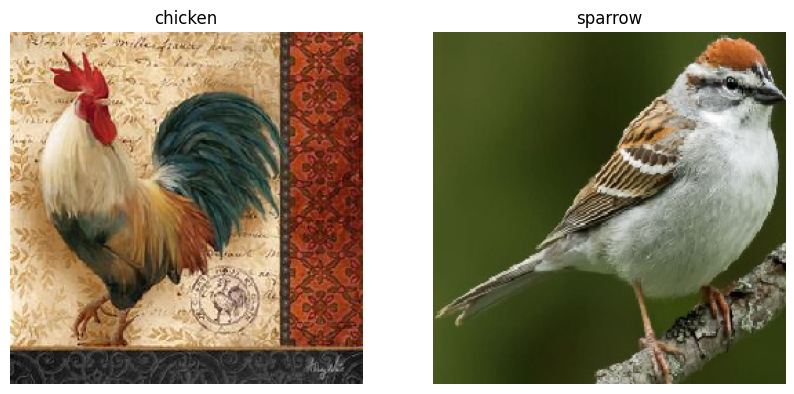

In [ ]:
from keras.preprocessing import image
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

#Loading the image and converting to 256*256 size 
img_pred_1=tf.keras.utils.load_img(os.path.join(pred,'chicken/619.jpeg'),target_size=(256,256))

img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
img_pred_1=np.expand_dims(img_pred_1, axis=0)


#Predicting the label
rslt= vgg16_final_model.predict(img_pred_1)


#Showing the label
l1=labels[np.argmax(rslt)]

ax1.imshow(img_pred_1[0]/255.0)
ax1.set_title(l1)
ax1.axis("off")

img_pred_2=tf.keras.utils.load_img(os.path.join(pred,'sparrow/124.jpg'),target_size=(256,256))

img_pred_2=tf.keras.utils.img_to_array(img_pred_2)
img_pred_2=np.expand_dims(img_pred_2, axis=0)


#Predicting the label
rslt= vgg16_final_model.predict(img_pred_2)


#Showing the label
l2=labels[np.argmax(rslt)]

ax2.imshow(img_pred_2[0]/255.0)
ax2.set_title(l2)
ax2.axis("off")

plt.show()